# _Data analysis bootcamp:_ Diffraction spectrometer

A whirlwind introdoction to using Python to analyse data for the diffraction spectrometer experiment of PHY2CLP.

## Preliminaries

First we import some standard packages:
  * ``numpy`` (numerical Python) for math functions;
  * ``pandas`` for slicing and dicing tables of indexed data; and
  * ``matplotlib.pyplot`` for plotting.
  
In each case, we assign these imported packages a short alias (``np``, ``pd``, and ``plt`` respectively) to make calling their methods less verbose.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Finally we increase the resolution of the printed graphics from ``matplotlib``.

In [80]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110

## Data import and conditioning

Import the data from a specified Excel sheet, indexing the resulting pandas ``DataFrame`` object by the known wavelength.

In [17]:
df = pd.read_excel('PHY2CLPDiffractionData.xlsx', 
                   index_col=0,
                   sheet_name='GaryLennonWill')

df

,Wavelength (Å),x (m=+1),x (m=-1),y
Mercury line,,,,
Y2,5791.0,193.5,197.0,208.0
Y1,5770.0,192.0,196.0,208.0
G,5461.0,173.0,178.0,208.0
B,4916.0,NaN,NaN,NaN
BV,4358.0,122.0,NaN,208.0
wV,4077.0,NaN,NaN,NaN
V,4047.0,110.0,NaN,208.0
?,NaN,96.9,NaN,208.0


_Note:_ Pandas inserts ``NaN`` (not a number) for blank cells in the spreadsheet. This is useful for us to keep track of missing values.

We then determine a correction for each value of \(x\) (the transverse distance of a diffracted line from the optical axis) in the instances where both $m=1$ and $m=-1$ orders were measured.

In [18]:
x_errors = (df['x (m=-1)'] - df['x (m=+1)'])/2
x_errors

Mercury line
Y2    1.75
Y1    2.00
G     2.50
B      NaN
BV     NaN
wV     NaN
V      NaN
?      NaN
dtype: float64

The average of these corrections is given by the following value (in mm):

In [19]:
x_error_avg = x_errors.mean()
x_error_avg

2.0833333333333335

For the lines where an $m=-1$ order wasn't measured, we use the mean value above for the correction. Below, we fill in the missing values of the ``x_errors`` series by replacing the ``NaN`` values with the above mean. 

_Note:_ The ``inplace=True`` argument to ``fillna`` reassigns the value of ``x_errors`` so that we don't have to prepend ``x_errors = `` to this command.

In [20]:
x_errors.fillna(x_error_avg, inplace=True)
x_errors

Mercury line
Y2    1.750000
Y1    2.000000
G     2.500000
B     2.083333
BV    2.083333
wV    2.083333
V     2.083333
?     2.083333
dtype: float64

We are now ready to definitively declare a set of $x$ positions based on the correction. Let's add these as a column of the ``df`` table (a pandas ``DataFrame``).

In [21]:
df['x'] = df['x (m=+1)'] + x_errors

In [22]:
df

,Wavelength (Å),x (m=+1),x (m=-1),y,x
Mercury line,,,,,
Y2,5791.0,193.5,197.0,208.0,195.250000
Y1,5770.0,192.0,196.0,208.0,194.000000
G,5461.0,173.0,178.0,208.0,175.500000
B,4916.0,NaN,NaN,NaN,NaN
BV,4358.0,122.0,NaN,208.0,124.083333
wV,4077.0,NaN,NaN,NaN,NaN
V,4047.0,110.0,NaN,208.0,112.083333
?,NaN,96.9,NaN,208.0,98.983333


As we continue our analysis, we'd like to only keep rows that satisfy the following conditions:
  * There is a known wavelength (i.e. not the '?' row), and
  * There is a value of $x$ and $y$.
  
If we were to drop the $x\, (m=-1)$ column, this would correspond to rows that contain no ``NaN``s.

In [55]:
subdf = df.drop(['x (m=-1)', 'x (m=+1)'], axis=1)
subdf.dropna(inplace=True)
subdf

,Wavelength (Å),y,x
Mercury line,,,
Y2,5791.0,208.0,195.250000
Y1,5770.0,208.0,194.000000
G,5461.0,208.0,175.500000
BV,4358.0,208.0,124.083333
V,4047.0,208.0,112.083333


## Calculating the diffraction angle and uncertatinty

We now extract the $x$ and $y$ columns as separate variables, and compute $\theta = \tan^{-1}(x/y)$ and $\sin \theta$.

In [56]:
x = subdf['x']
y = subdf['y']
theta = np.arctan(x / y)
sin_theta = np.sin(theta)
sin_theta

Mercury line
Y2    0.684407
Y1    0.682068
G     0.644871
BV    0.512318
V     0.474373
dtype: float64

We are now equipped to evaluate $u(\sin \theta)$, the uncertainty in $\sin\theta$, which is necessary for weighted linear regression to $(\lambda, \sin\theta)$ data.

First we note that:
$$\sin\theta = \sin(\tan^{-1}(x/y)) = \frac{x}{\sqrt{x^2 + y^2}} \, .$$
From this we can calculate the uncertainty in $\sin\theta$ from $u(x)$ and $u(y)$, the uncertainties in the measured lengths:

$$\begin{align} u(\sin\theta) &= \sqrt{u(x)^2 \left(\frac{\partial(\sin\theta)}{\partial x}\right)^2 + u(y)^2 \left(\frac{\partial(\sin\theta)}{\partial y}\right)^2} \\
&= \sqrt{\frac{u(x)^2 x^2 y^2 + u(y)^2 y^4}{(x^2 + y^2)^3}} \, ,\end{align}$$
since
$$\begin{align} \frac{\partial(\sin\theta)}{\partial x} &= \frac{y^2}{(x^2 + y^2)^{3/2}} \; ; \\
 \frac{\partial(\sin\theta)}{\partial y} &= -\frac{xy}{(x^2 + y^2)^{3/2}} \, . \end{align}$$
 
Let's define a function which takes as arguments the two measured lengths and their uncertainties and returns $u(\sin\theta)$.

In [50]:
def uncertainty(x, y, ux=0.5, uy=0.5):
    denominator = (x**2 + y**2)**3
    numerator = (ux * x * y)**2 + (uy * x)**2
    return np.sqrt(numerator / denominator)

We now define a series of values for this uncertainty, evaluatig the above function element-wise on the ``x`` and ``y`` series.

In [57]:
u_sin_theta = uncertainty(x, y)
u_sin_theta

Mercury line
Y2    0.000875
Y1    0.000877
G     0.000906
BV    0.000908
V     0.000884
dtype: float64

Add some choice columns to the analysis table.

In [58]:
subdf['sin(theta)'] = sin_theta
subdf['u(sin(theta))'] = u_sin_theta

## _Analysis paradigm 1:_ Measured wavelengths from the known grating period

Suppose we were provided the grating with a known period ($G = 1200$ lines per mm). Then our measurement of diffraction angles for a given order is essentially a measurement of the wavelengths of each spectral component of the lamp.

The imputed wavelength is given by (for $m=1$):
$$\lambda = d \sin \theta .$$

We've 'measured' $\sin\theta$ with an uncertainty of $u(\sin\theta)$, which makes calculating the uncertainty in the measured wavelength simple, as $\lambda$ will have the same fractional error as $\sin\theta$, i.e. 

$$\begin{align}\frac{u(\lambda)}{\lambda} &= \frac{u(\sin\theta)}{\sin\theta} \\ \Rightarrow u(\lambda) &= \lambda \frac{u(\sin\theta)}{\sin\theta} \, . \end{align}$$

In [75]:
G_actual = 1200   # lines per mm
mm = 1e-3         # millimeters SI constant
nm = 1e-9         # nanometers SI constant

# Grating period in meters
d_actual = mm/G_actual

# Measured wavelengths from known grating period
lambda_measured = d_actual * sin_theta
subdf['lambda measured (nm)'] = lambda_measured / nm

# The actual wavelengths of those measured
lambda_actual = subdf.iloc[:,0] * 1e-10
subdf['lambda actual (nm)'] = lambda_actual / nm

# The uncertainty in the wavelengths measured
u_lambda_measured = lambda_measured * u_sin_theta / sin_theta
subdf['u(lambda) measured (nm)'] = u_lambda_measured / nm

Find the fractional error in each wavelength measurement, and print a summary of the measured wavelengths.

In [76]:
fractional_error = (lambda_measured - lambda_actual) / lambda_actual
subdf['% error'] = 100 * fractional_error

subdf[['lambda actual (nm)', 'lambda measured (nm)', 'u(lambda) measured (nm)', '% error']]

,lambda actual (nm),lambda measured (nm),u(lambda) measured (nm),% error
Mercury line,,,,
Y2,579.1,570.339491,0.728818,-1.512780
Y1,577.0,568.389731,0.730695,-1.492248
G,546.1,537.392449,0.754608,-1.594497
BV,435.8,426.931975,0.756920,-2.034884
V,404.7,395.311016,0.736437,-2.319986


## _Analysis paradigm 2:_ Finding the grating period from known wavelengths
    
Suppose instead that we did not know the grating period, but could identify a known wavelength for each observed line. Since $\sin\theta$ is proportional to $\lambda$, we can do linear regression to data in the form of $(\lambda_{\text{actual}}, \sin\theta)$ pairs, and find the grating period $G=1/d$ from the slope.

### Plotting with error bars

Let's first plot $\sin\theta$ vs $\lambda_{\text{actual}}$ in nanometres.

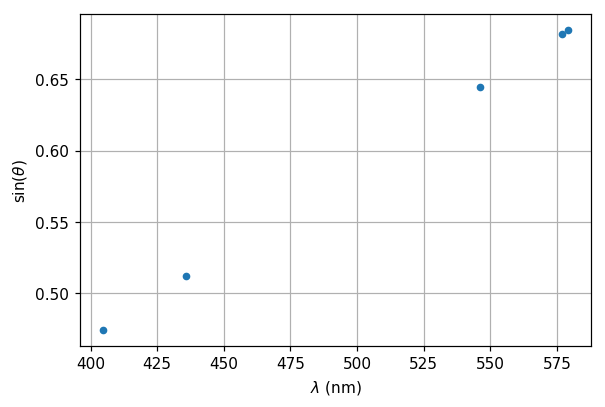

In [83]:
lambda_nm = lambda_actual / nm

plt.errorbar(lambda_nm, sin_theta, u_sin_theta, 
            marker='o', ls='none', ms=4)
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sin(\theta)$')
plt.grid()

The error bars are barely visible, if at all.

### Weighted linear regression using ``lmfit``

We use the excellent ``lmfit`` package to do weighted linear regression. All we need is the ``LienarModel`` class, which we'll create an _instance_ of, called ``model``.

In [85]:
from lmfit.models import LinearModel
model = LinearModel()

To perform the regression, we just need to call the ``fit`` method of ``model``, passing it the measured values, the values of the independent variable, and the weights for the regression. The latter will be the reciprocal of the uncertainties, so that those points with a larger uncertainty should contribute less to the fit.

In [87]:
fit = model.fit(sin_theta, x=lambda_nm, weights=1/u_sin_theta)
print(fit.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 5
    # variables        = 2
    chi-square         = 0.19209914
    reduced chi-square = 0.06403305
    Akaike info crit   = -12.2959081
    Bayesian info crit = -13.0770323
[[Variables]]
    intercept: -0.01257873 +/- 7.0096e-04 (5.57%) (init = 0)
    slope:      0.00120380 +/- 1.3616e-06 (0.11%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(intercept, slope) = -0.990



We can extract the slope using the following syntax:

In [89]:
slope = fit.params['slope']
slope

<Parameter 'slope', value=0.0012038037459667647 +/- 1.36e-06, bounds=[-inf:inf]>

This is $G$ in funny units, since we specified the wavelength in nanometers when fitting. The actual value of $G$ in units of lines per mm is:

In [91]:
mm / nm * slope.value

1203.8037459667648

And the standard error of the slope in these units is:

In [92]:
mm / nm * slope.stderr

1.3615711178686922

We can also get the percentage error from the fractional error:

In [94]:
frac_error = slope.stderr / slope.value
print(100 * frac_error)

0.11310573857495566


There is a very helpful package called uncertainties for handling and printing numbers with uncertainties. Here's some usage examples:

In [96]:
from uncertainties import ufloat

# Report the imputed grating frequency in lines per mm
G_measured = ufloat(slope.value, slope.stderr) / nm
print('G (measured) = ', '{0:.2u}'.format(mm * G_measured))
print('G (measured) = ', '{0:.1uS}'.format(mm * G_measured))

# Get the percentage error
print('Error = {:.1f}% (one part in {:d})'.format(100*frac_error, int(1/frac_error)))

G (measured) =  1203.8+/-1.4
G (measured) =  1204(1)
Error = 0.1% (one part in 884)


### Visualising the fit

A trendline is attained by evaluating the model at the fitted parameters, and connecting the points with a line. We can evaluate the model function in multiple ways.

#### Method 1: Defining a model function explicitly

In [98]:
def linear(x, slope, intercept):
    return slope * x + intercept

linear(lambda_nm, **fit.params)

Mercury line
Y2    0.684544
Y1    0.682016
G     0.644818
BV    0.512039
V     0.474601
Name: Wavelength (Å), dtype: float64

#### Method 2: ``lmfit.Model``'s ``eval`` method

In [99]:
model.eval(fit.params, x=lambda_nm)

Mercury line
Y2    0.684544
Y1    0.682016
G     0.644818
BV    0.512039
V     0.474601
Name: Wavelength (Å), dtype: float64

#### Method 3: ``lmfit.Model.ModelResult``'s ``eval`` method

In [100]:
sin_theta_fit = fit.eval()
sin_theta_fit

Mercury line
Y2    0.684544
Y1    0.682016
G     0.644818
BV    0.512039
V     0.474601
Name: Wavelength (Å), dtype: float64

#### Plotting the fit using the ``lmfit.Model.ModelResult``'s convenient ``plot`` method

This is way easier than generating the plot manually (below), and can be saved using the ``plt.savefig`` method.

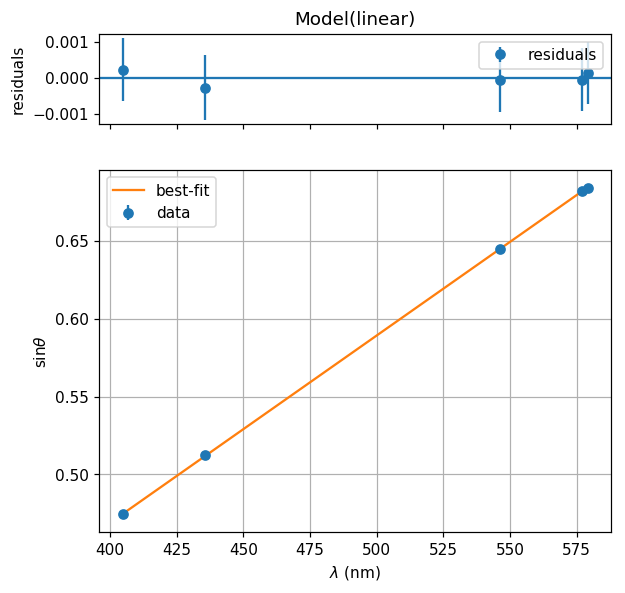

In [102]:
fit.plot(xlabel=r'$\lambda$ (nm)', ylabel=r'$\sin \theta$')
plt.grid(True)
plt.savefig('diffraction_lab.png')

#### Plotting the fit with the residuals manually

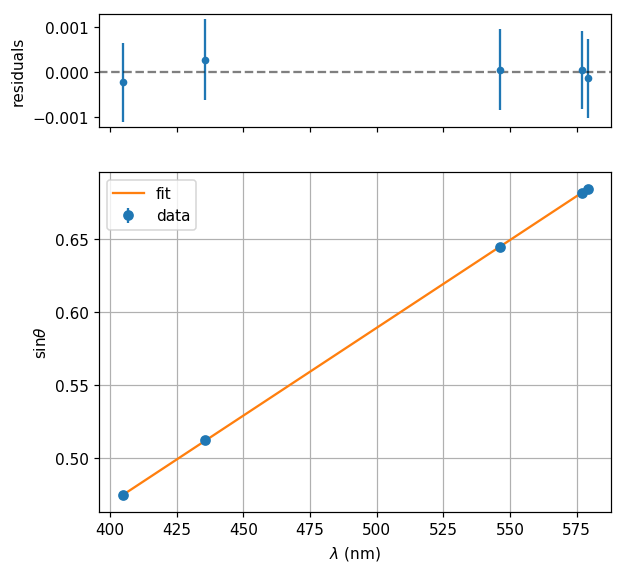

In [103]:
residuals = sin_theta - sin_theta_fit
fig = plt.figure(figsize=[6, 6])
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
ax0 = plt.subplot(gs[0])
ax0.errorbar(lambda_nm, residuals, u_sin_theta,
             marker='o', ms=4, ls='none')
ax0.axhline(y=0, c='k', alpha=0.5, ls='--')
ax0.set_ylabel('residuals')
ax0.xaxis.set_ticklabels([])
ax1 = plt.subplot(gs[1])
ax1.errorbar(lambda_nm, sin_theta, u_sin_theta, 
             marker='o', ls='none', label='data')
ax1.plot(lambda_nm, sin_theta_fit, '-', label='fit')
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sin \theta$')
ax1.grid(True)
ax1.legend()